<a href="https://colab.research.google.com/github/reiple/Collab/blob/main/%5B2023_10_Samsung%5D_%5Bngram_lm_and_word_embeddings%5D_%5BStudent%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# N-gram Language Model & Word Embeddings

In [1]:
import tqdm

# We use PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

In [2]:
# Gensim
#!pip install gensim==3.8.3
import gensim.downloader as api

### 1.1 Loading text

In [3]:
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt -O shakespeare.txt
shakespeare = open("shakespeare.txt").readlines()



--2023-10-10 06:00:12--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘shakespeare.txt’

shakespeare.txt     100%[===================>]   1.06M  --.-KB/s    in 0.05s   

2023-10-10 06:00:12 (22.0 MB/s) - ‘shakespeare.txt’ saved [1115394/1115394]



In [4]:
# First lines
shakespeare[:10]

['First Citizen:\n',
 'Before we proceed any further, hear me speak.\n',
 '\n',
 'All:\n',
 'Speak, speak.\n',
 '\n',
 'First Citizen:\n',
 'You are all resolved rather to die than to famish?\n',
 '\n',
 'All:\n']

In [5]:
# last lines
shakespeare[-10:]

["It is a sleepy language and thou speak'st\n",
 'Out of thy sleep. What is it thou didst say?\n',
 'This is a strange repose, to be asleep\n',
 'With eyes wide open; standing, speaking, moving,\n',
 'And yet so fast asleep.\n',
 '\n',
 'ANTONIO:\n',
 'Noble Sebastian,\n',
 "Thou let'st thy fortune sleep--die, rather; wink'st\n",
 'Whiles thou art waking.\n']

In [6]:
len(shakespeare)

40000

In [7]:
word_to_ix = {"hello": 0, "world": 1}
embeds = nn.Embedding(2, 5)  # 2 words in vocab, 5 dimensional embeddings
lookup_tensor = torch.tensor([word_to_ix["hello"]], dtype=torch.long)
hello_embed = embeds(lookup_tensor)
print(hello_embed)

tensor([[ 0.6614,  0.2669,  0.0617,  0.6213, -0.4519]],
       grad_fn=<EmbeddingBackward0>)


In [8]:
# We will use Shakespeare Sonnet 2
text_data = ' '.join(shakespeare[:10000]).split()
# we should tokenize the input, but we will ignore that for now

In [9]:
print(text_data[:20])

['First', 'Citizen:', 'Before', 'we', 'proceed', 'any', 'further,', 'hear', 'me', 'speak.', 'All:', 'Speak,', 'speak.', 'First', 'Citizen:', 'You', 'are', 'all', 'resolved', 'rather']


### 1.2 Training trigram model

In [10]:
# Hyperparams
CONTEXT_SIZE = 2
EMBEDDING_DIM = 10

In [11]:


# build a list of tuples.
# Each tuple is ([ word_i-CONTEXT_SIZE, ..., word_i-1 ], target word)
all_ngrams = [
    (
        [text_data[i - CONTEXT_SIZE + j] for j in range(CONTEXT_SIZE)],
        text_data[i]
    )
    for i in range(CONTEXT_SIZE, len(text_data))
]



In [12]:
# Exercise: Print the first 3, just so you can see what they look like.
print(all_ngrams[:3])

[(['First', 'Citizen:'], 'Before'), (['Citizen:', 'Before'], 'we'), (['Before', 'we'], 'proceed')]


In [13]:
# Exercise: How many ngrams are there in total?
total_ngrams = len(all_ngrams)
print(f"Total ngrams: {total_ngrams}")

Total ngrams: 48249


In [14]:
# Exercise: How many 1-grams (unique words) are there in total?
vocab = set(text_data)
unique_words = len(vocab)
print(f"Total 1-grams (unique words): {unique_words}")

Total 1-grams (unique words): 9798


In [15]:
# Exercise: Using the 1-gram words, create a vocabulary dictionary the maps word to idx
word_to_ix = {word: idx for idx, word in enumerate(vocab)}
print(f"Vocabulary mapping: {word_to_ix}")

Vocabulary mapping: {'exercise,': 0, "establish'd": 1, 'subject.': 2, 'ghost,': 3, 'joyfully': 4, 'nurse.': 5, 'humble': 6, 'libels': 7, 'people:': 8, "o'erleap": 9, 'raiment': 10, 'gave': 11, 'report.': 12, 'Back,': 13, 'turn': 14, 'Falsely': 15, 'apprehension': 16, 'prescription': 17, 'envied': 18, 'yond': 19, 'pursuing': 20, 'tribunes,--': 21, 'enforcement': 22, 'obstinate.': 23, 'then,': 24, 'know--as': 25, 'cushion': 26, 'likes': 27, 'that:': 28, 'chop': 29, 'bodies': 30, 'canst': 31, 'jealous': 32, 'bow': 33, 'lift': 34, 'refuse': 35, 'instant': 36, 'remorse': 37, 'nothing': 38, 'it,--as,': 39, 'time': 40, 'behalf': 41, 'Smile': 42, 'sharp-provided': 43, 'razed': 44, 'Thyself': 45, 'Ludlow.': 46, 'vent.': 47, 'place,': 48, 'turns': 49, "war's": 50, 'little,': 51, 'big': 52, "poor'st": 53, 'Aufidius': 54, 'Stand': 55, 'dog!': 56, 'which': 57, 'occupation': 58, 'treading:': 59, 'substitute': 60, 'Spread': 61, "school'd": 62, 'disgrace': 63, 'Sir': 64, 'malign': 65, 'declines;': 66,

In [16]:
# 실습: split the ngrams into a training and test set
# Assuming an 80-20 split for train-test
# split_idx = _
split_idx = int(len(word_to_ix) * 0.8)

# train_ngrams = all_ngrams[_]
# test_ngrams = all_ngrams[_]
train_ngrams = all_ngrams[:split_idx]
test_ngrams = all_ngrams[split_idx:]

print(f"Training ngrams: {len(train_ngrams)}")
print(f"Test ngrams: {len(test_ngrams)}")

Training ngrams: 7838
Test ngrams: 40411


In [17]:
# Training hyperparams
train_epochs = 5
learning_rate = 0.001
BATCH_SIZE = 32

In [18]:
class NGramLanguageModeler(nn.Module):

    def __init__(self, vocab_size, embedding_dim, context_size):
        super(NGramLanguageModeler, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size * embedding_dim, 128)
        self.linear2 = nn.Linear(128, vocab_size)

    def forward(self, inputs):
        embeds = self.embeddings(inputs).view((1, -1))
        out = F.relu(self.linear1(embeds))
        out = self.linear2(out)
        log_probs = F.log_softmax(out, dim=1)
        return log_probs

In [19]:
# 실습: train loss computation
losses = []
loss_function = nn.NLLLoss()
model = NGramLanguageModeler(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE)
model = model.cuda()
model.train()
#optimizer = optim.SGD(model.parameters(), lr=0.001)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in tqdm.tqdm(range(train_epochs)):
    total_loss = 0
    batch_loss = 0  # To accumulate loss over instances

    for i, (context, target) in enumerate(tqdm.tqdm(train_ngrams, position=0, leave=True)):
        context_idxs = torch.tensor([word_to_ix[w] for w in context], dtype=torch.long).cuda()
        target_idx = torch.tensor([word_to_ix[target]], dtype=torch.long).cuda()

        # Forward pass
        log_probs = model(context_idxs)

        # Compute loss
        loss = loss_function(log_probs, target_idx)

        # Accumulate loss
        batch_loss += loss.item()

        # Backward pass (compute gradients)
        loss.backward()

        # Update parameters every BATCH_SIZE instances
        if (i+1) % BATCH_SIZE == 0 or i == len(train_ngrams)-1:
            optimizer.step()  # Apply the gradients
            model.zero_grad()  # Zero the gradients

            # total_loss += _  # Update the total loss
            # batch_loss = _  # Reset the batch loss
            # total_loss += batch_loss.item()
            total_loss += batch_loss
            batch_loss = 0

    # Log the total loss for this epoch
    losses.append(total_loss)
    print(f"\nEpoch {epoch+1}/{train_epochs}, Loss: {total_loss:.4f}")

 20%|██        | 1/5 [00:07<00:29,  7.50s/it]


Epoch 1/5, Loss: 62649.4442


 40%|████      | 2/5 [00:14<00:20,  6.97s/it]


Epoch 2/5, Loss: 48521.2794


 60%|██████    | 3/5 [00:21<00:14,  7.01s/it]


Epoch 3/5, Loss: 42930.9786


 80%|████████  | 4/5 [00:27<00:06,  6.90s/it]


Epoch 4/5, Loss: 37040.9418


100%|██████████| 5/5 [00:34<00:00,  6.98s/it]


Epoch 5/5, Loss: 30670.9231


### 1.3 Testing trigram model

In [20]:
def predict(context, k=3):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    context_idxs = torch.tensor([word_to_ix[w] for w in context], dtype=torch.long).to(device)
    log_probs = model(context_idxs)
    top_k = torch.topk(log_probs, k)[1].view(-1)
    ix_to_word = {ix: word for word, ix in word_to_ix.items()}

    return [ix_to_word[ix.item()] for ix in top_k]


In [21]:
def display_predictions(ngram, predictions):
    context = " ".join(ngram[0])
    label = ngram[1]
    print(f"\nText: {context} | Label: {label}")
    for i, prediction in enumerate(predictions):
        print(f"  Prediction #{i+1}: {prediction}")



In [22]:
# Prediction on Train ngrams
for ngram in train_ngrams[:10]:
    predictions = predict(ngram[0], k=3)
    display_predictions(ngram, predictions)


Text: First Citizen: | Label: Before
  Prediction #1: Ye're
  Prediction #2: He's
  Prediction #3: Well,

Text: Citizen: Before | Label: we
  Prediction #1: the
  Prediction #2: you
  Prediction #3: Menenius

Text: Before we | Label: proceed
  Prediction #1: proceed
  Prediction #2: the
  Prediction #3: have

Text: we proceed | Label: any
  Prediction #1: rakes:
  Prediction #2: I
  Prediction #3: the

Text: proceed any | Label: further,
  Prediction #1: further,
  Prediction #2: I
  Prediction #3: the

Text: any further, | Label: hear
  Prediction #1: I
  Prediction #2: inventory
  Prediction #3: the

Text: further, hear | Label: me
  Prediction #1: the
  Prediction #2: Against
  Prediction #3: if

Text: hear me | Label: speak.
  Prediction #1: speak.
  Prediction #2: drum,
  Prediction #3: Though

Text: me speak. | Label: All:
  Prediction #1: MENENIUS:
  Prediction #2: the
  Prediction #3: of

Text: speak. All: | Label: Speak,
  Prediction #1: Speak,
  Prediction #2: accused
  Pred

In [23]:
# Prediction on Test ngrams
for ngram in test_ngrams[:10]:
    predictions = predict(ngram[0], k=3)
    display_predictions(ngram, predictions)


Text: COMINIUS: Ever | Label: right.
  Prediction #1: an
  Prediction #2: in
  Prediction #3: to

Text: Ever right. | Label: CORIOLANUS:
  Prediction #1: in
  Prediction #2: the
  Prediction #3: MENENIUS:

Text: right. CORIOLANUS: | Label: Menenius
  Prediction #1: in
  Prediction #2: I
  Prediction #3: the

Text: CORIOLANUS: Menenius | Label: ever,
  Prediction #1: the
  Prediction #2: is
  Prediction #3: MENENIUS:

Text: Menenius ever, | Label: ever.
  Prediction #1: rob
  Prediction #2: the
  Prediction #3: you

Text: ever, ever. | Label: Herald:
  Prediction #1: and
  Prediction #2: your
  Prediction #3: the

Text: ever. Herald: | Label: Give
  Prediction #1: fit
  Prediction #2: the
  Prediction #3: I

Text: Herald: Give | Label: way
  Prediction #1: love.
  Prediction #2: the
  Prediction #3: arms

Text: Give way | Label: there,
  Prediction #1: MENENIUS:
  Prediction #2: the
  Prediction #3: come,

Text: way there, | Label: and
  Prediction #1: not,
  Prediction #2: MENENIUS:
 

In [24]:
def user_predict(words, k=3):
    """
    Function to predict the next word(s) given a user-defined input of words.

    Parameters:
    - words (list of str): User-defined input words.
    - k (int): Number of top predictions to return.

    Returns:
    - predictions (list of str): Predicted word(s).
    """
    if len(words) != CONTEXT_SIZE:
        raise ValueError(f"Expected {CONTEXT_SIZE} words for context, got {len(words)}")

    predictions = predict(words, k=k)

    return predictions


In [25]:
user_input = ["My", "dear"]
predictions = user_predict(user_input, k=3)

print(f"Context: {' '.join(user_input)}")
print("Predicted next words:")
for i, word in enumerate(predictions):
    print(f"  #{i+1}: {word}")


Context: My dear
Predicted next words:
  #1: the
  #2: of
  #3: MENENIUS:


In [ ]:
# 실습: fill the blank (???)
def generate_text(start_words, n, model, word_to_ix, ix_to_word):
    """
    Generate a sequence of n words based on the start_words.

    Parameters:
    - start_words (list): The starting words to use as context.
    - n (int): The number of words to generate.
    - model (nn.Module): The trained language model.
    - word_to_ix (dict): A dictionary mapping words to indices.
    - ix_to_word (dict): A dictionary mapping indices to words.

    Returns:
    - (list): A list of words generated by the model.
    """
    model.eval()  # Set the model to evaluation mode
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    generated_words = start_words
    context = start_words

    for _ in range(n):
        # Convert words to indices
        context_idxs = ???

        # Get predictions from model
        with torch.no_grad():
            log_probs = model(context_idxs)

        # Get the most likely word index
        _, predicted_idx = torch.max(log_probs, 1)

        # Convert index to word
        predicted_word = ix_to_word[predicted_idx.item()]

        # Add predicted word to the generated words and update context
        generated_words.append(predicted_word)
        context = generated_words[-2:]

    return generated_words


In [ ]:
# Example usage:
start_words = ["The", "quick"]
n = 10  # Number of words to generate

ix_to_word = {ix: word for word, ix in word_to_ix.items()}

generated_words = generate_text(start_words, n, model, word_to_ix, ix_to_word)

print(" ".join(generated_words))

The quick of my sight! bisson and have been my son; the


### 2 Loading pretrained embedding

In [26]:
import gensim.downloader as api
glove_model = api.load("glove-twitter-25")
EMBEDDING_DIM = 25
#glove_model.most_similar(positive=['fruit', 'flower'], topn=1)

[==================================================] 100.0% 104.8/104.8MB downloaded


In [28]:
glove_model['flower'].shape

(25,)

In [29]:
glove_model['flower']

array([-1.5308  , -1.1939  ,  0.58712 ,  0.51104 , -0.069961,  0.239   ,
        0.94258 , -0.35138 ,  0.68519 , -0.40802 ,  1.0201  ,  0.51157 ,
       -2.632   , -0.21915 , -1.5487  , -0.21886 ,  0.76466 , -0.26767 ,
        0.20703 ,  1.3776  , -1.0291  , -0.17614 , -0.010165,  0.33209 ,
       -0.14012 ], dtype=float32)

In [30]:
CONTEXT_SIZE = 2
MODEL_DIM = 1024

In [31]:
# Lets create the ngram function
def sent2ngram(sentence, context_size):
  ngrams = [
    (
        [sentence[i - context_size + j] for j in range(context_size)],
        sentence[i]
    )
    for i in range(context_size, len(text_data))
]
  return ngrams

In [32]:
import nltk
nltk.download('punkt')
nltk.word_tokenize(shakespeare[0])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


['First', 'Citizen', ':']

In [33]:


class NGramLanguageModeler(nn.Module):

    def __init__(self, vocab_size, embedding_dim, context_size):
        super(NGramLanguageModeler, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size * embedding_dim, MODEL_DIM)
        self.linear2 = nn.Linear(MODEL_DIM, vocab_size)

    def forward(self, inputs):
        embeds = self.embeddings(inputs).view((1, -1))
        out = F.relu(self.linear1(embeds))
        out = self.linear2(out)
        log_probs = F.log_softmax(out, dim=1)
        return log_probs

In [34]:
def init_embeddings(model, glove_model, vocab):
  n = 0
  for word in vocab:
    #print(word)
    if word in glove_model:
      n += 1
      model.embeddings.weight.data[word_to_ix[word]] = torch.cuda.FloatTensor(glove_model[word])
      #print(word)
  print(f"{n} embeddings initialized, out of {len(vocab)} vocab")


In [35]:
# Training hyperparams
train_epochs = 5
learning_rate = 0.001
BATCH_SIZE = 128
EMBEDDING_DIM = 25

In [36]:

losses = []
loss_function = nn.NLLLoss()
model = NGramLanguageModeler(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE)
model = model.cuda()
init_embeddings(model, glove_model, vocab) # Use the glove embeddings!
model.train()
#optimizer = optim.SGD(model.parameters(), lr=0.001)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in tqdm.tqdm(range(train_epochs)):
    total_loss = 0
    batch_loss = 0  # To accumulate loss over instances

    for i, (context, target) in enumerate(tqdm.tqdm(train_ngrams, position=0, leave=True)):
        context_idxs = torch.tensor([word_to_ix[w] for w in context], dtype=torch.long).cuda()
        target_idx = torch.tensor([word_to_ix[target]], dtype=torch.long).cuda()

        # Forward pass
        log_probs = model(context_idxs)

        # Compute loss
        loss = loss_function(log_probs, target_idx)

        # Accumulate loss
        batch_loss += loss.item()

        # Backward pass (compute gradients)
        loss.backward()

        # Update parameters every BATCH_SIZE instances
        if (i+1) % BATCH_SIZE == 0 or i == len(train_ngrams)-1:
            optimizer.step()  # Apply the gradients
            model.zero_grad()  # Zero the gradients

            total_loss += batch_loss  # Update the total loss
            batch_loss = 0  # Reset the batch loss

    # Log the total loss for this epoch
    losses.append(total_loss)
    print(f"\nEpoch {epoch+1}/{train_epochs}, Loss: {total_loss:.4f}")


<ipython-input-34-6c6f2dc05ac0>:7: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  model.embeddings.weight.data[word_to_ix[word]] = torch.cuda.FloatTensor(glove_model[word])


3502 embeddings initialized, out of 9798 vocab


 20%|██        | 1/5 [00:12<00:50, 12.50s/it]


Epoch 1/5, Loss: 62374.0460


 40%|████      | 2/5 [00:25<00:37, 12.55s/it]


Epoch 2/5, Loss: 45370.7662


 60%|██████    | 3/5 [00:37<00:25, 12.57s/it]


Epoch 3/5, Loss: 34179.0472


 80%|████████  | 4/5 [00:51<00:13, 13.20s/it]


Epoch 4/5, Loss: 23940.9514


100%|██████████| 5/5 [01:04<00:00, 12.87s/it]


Epoch 5/5, Loss: 18669.2519


In [37]:
# Prediction on Train ngrams
for ngram in train_ngrams[:10]:
    predictions = predict(ngram[0], k=3)
    display_predictions(ngram, predictions)


Text: First Citizen: | Label: Before
  Prediction #1: We
  Prediction #2: Ye're
  Prediction #3: Well,

Text: Citizen: Before | Label: we
  Prediction #1: the
  Prediction #2: for
  Prediction #3: one

Text: Before we | Label: proceed
  Prediction #1: proceed
  Prediction #2: the
  Prediction #3: are

Text: we proceed | Label: any
  Prediction #1: any
  Prediction #2: in
  Prediction #3: for

Text: proceed any | Label: further,
  Prediction #1: further,
  Prediction #2: the
  Prediction #3: thing.

Text: any further, | Label: hear
  Prediction #1: hear
  Prediction #2: and
  Prediction #3: in

Text: further, hear | Label: me
  Prediction #1: me
  Prediction #2: you
  Prediction #3: the

Text: hear me | Label: speak.
  Prediction #1: speak.
  Prediction #2: smear'd;
  Prediction #3: clip

Text: me speak. | Label: All:
  Prediction #1: All:
  Prediction #2: for
  Prediction #3: me.

Text: speak. All: | Label: Speak,
  Prediction #1: Speak,
  Prediction #2: in
  Prediction #3: for


In [38]:
# Prediction on Test ngrams
for ngram in test_ngrams[:10]:
    predictions = predict(ngram[0], k=3)
    display_predictions(ngram, predictions)


Text: COMINIUS: Ever | Label: right.
  Prediction #1: not
  Prediction #2: the
  Prediction #3: I

Text: Ever right. | Label: CORIOLANUS:
  Prediction #1: I
  Prediction #2: MENENIUS:
  Prediction #3: The

Text: right. CORIOLANUS: | Label: Menenius
  Prediction #1: By
  Prediction #2: the
  Prediction #3: The

Text: CORIOLANUS: Menenius | Label: ever,
  Prediction #1: Agrippa;
  Prediction #2: I
  Prediction #3: a

Text: Menenius ever, | Label: ever.
  Prediction #1: you
  Prediction #2: is
  Prediction #3: I

Text: ever, ever. | Label: Herald:
  Prediction #1: I
  Prediction #2: in
  Prediction #3: to

Text: ever. Herald: | Label: Give
  Prediction #1: the
  Prediction #2: We
  Prediction #3: or

Text: Herald: Give | Label: way
  Prediction #1: MENENIUS:
  Prediction #2: to
  Prediction #3: I

Text: Give way | Label: there,
  Prediction #1: the
  Prediction #2: you
  Prediction #3: a

Text: way there, | Label: and
  Prediction #1: You,
  Prediction #2: the
  Prediction #3: VOLUMNIA:


In [39]:
user_input = ["My", "dear"]
predictions = user_predict(user_input, k=3)

print(f"Context: {' '.join(user_input)}")
print("Predicted next words:")
for i, word in enumerate(predictions):
    print(f"  #{i+1}: {word}")


Context: My dear
Predicted next words:
  #1: the
  #2: you
  #3: my


In [40]:
# Example usage:
start_words = ["The", "quick"]
n = 10  # Number of words to generate

ix_to_word = {ix: word for word, ix in word_to_ix.items()}

generated_words = generate_text(start_words, n, model, word_to_ix, ix_to_word)

print(" ".join(generated_words))

NameError: ignored

### 3 Visualizing word embeddings

In [41]:
import numpy as np

# Get the interactive Tools for Matplotlib
%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.decomposition import PCA

from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

In [42]:
import gensim.downloader as api
# https://github.com/RaRe-Technologies/gensim-data
glove_model = api.load("glove-wiki-gigaword-300")

[==================================================] 100.0% 376.1/376.1MB downloaded


In [43]:
def analogy(x1, x2, y1):
    """
    The most_similar function finds the top-N most similar keys.
    Positive keys contribute positively towards the similarity, negative keys negatively.

    This method computes cosine similarity between a simple mean of the projection weight vectors of the given keys and the vectors for each key in the model.
    The method corresponds to the word-analogy and distance scripts in the original word2vec implementation.
    """
    result = glove_model.most_similar(positive=[y1, x2], negative=[x1])
    return result[0][0]

In [44]:
analogy('japan', 'japanese', 'korea')

'korean'

$\varphi(\text{japan})-\varphi(\text{japanese})=\varphi(\text{korea})-\varphi(x)$ \\
$\varphi(x)=\varphi(\text{japanese})-\varphi(\text{japan})+\varphi(\text{korea})$ \\
Choose $x$ such that the embedding of $x$ is close to $\varphi(\text{japanese})-\varphi(\text{japan})+\varphi(\text{korea})$.

In [45]:
analogy('king', 'man', 'queen')

'woman'

In [46]:
analogy('paltry', 'significant', 'banal')

'important'

In [47]:
analogy('opulent', 'wealth', 'powerful')

'strong'

In [48]:
analogy('regatta', 'oarsman', 'marathon') # failure cases

'swimmer'

In [49]:
analogy('diamond', 'baseball', 'court') # failure cases - we want baseball diamond and squash court. word vectors are limited in dealing with multiple semantics

'appeals'

In [50]:
analogy('one', 'ten', 'two',) # semantic vectors often have imprecise representation of numbers

'eleven'

In [51]:
def display_pca_scatterplot(model, words=None, sample=0):
    if words == None:
        if sample > 0:
            words = np.random.choice(list(model.key_to_index.keys()), sample)
        else:
            words = [ word for word in model.key_to_index.keys() ]

    word_vectors = np.array([model[w] for w in words])

    twodim = PCA().fit_transform(word_vectors)[:,:2]

    plt.figure(figsize=(6,6))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
    for word, (x,y) in zip(words, twodim):
        plt.text(x+0.05, y+0.05, word)

    plt.show()

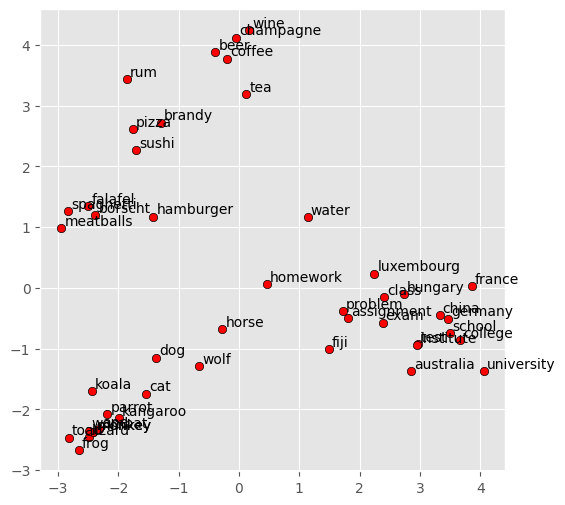

In [52]:
display_pca_scatterplot(glove_model,
                        ['coffee', 'tea', 'beer', 'wine', 'brandy', 'rum', 'champagne', 'water',
                         'spaghetti', 'borscht', 'hamburger', 'pizza', 'falafel', 'sushi', 'meatballs',
                         'dog', 'horse', 'cat', 'monkey', 'parrot', 'koala', 'lizard',
                         'frog', 'toad', 'monkey', 'ape', 'kangaroo', 'wombat', 'wolf',
                         'france', 'germany', 'hungary', 'luxembourg', 'australia', 'fiji', 'china',
                         'homework', 'assignment', 'problem', 'exam', 'test', 'class',
                         'school', 'college', 'university', 'institute'])

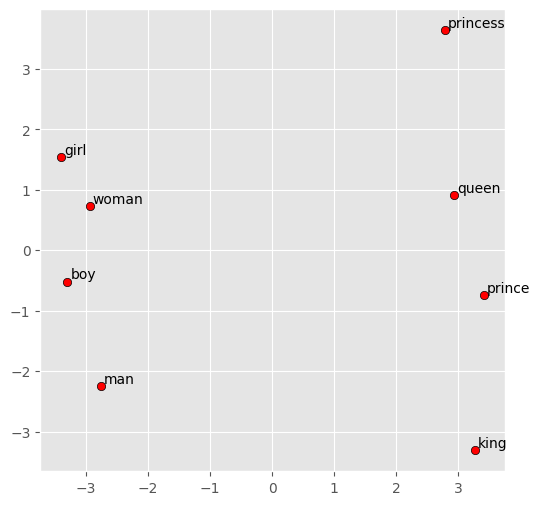

In [53]:
display_pca_scatterplot(glove_model,
                        ['woman', 'queen', 'man', 'king', 'girl', 'boy','prince', 'princess']             )

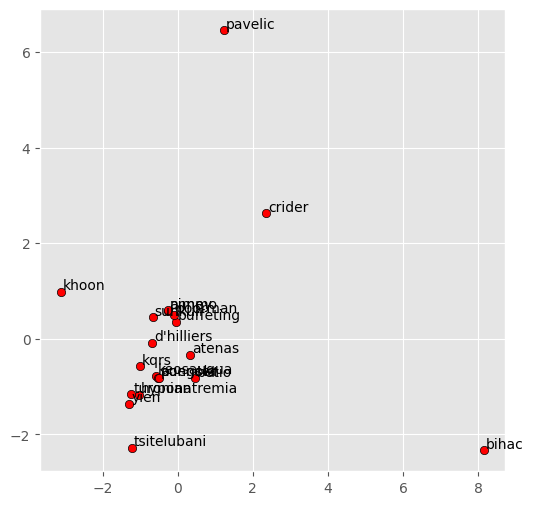

In [54]:
display_pca_scatterplot(glove_model, sample=20)